In [1]:
import datetime as dt
import pandas as pd
import  plotly.express as px 
import plotly.graph_objects as go

#Read US Covid deaths abd filter LA county 
US_Deaths_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
US_Deaths_df = pd.read_csv(US_Deaths_url, error_bad_lines=True)
US_Deaths_df=US_Deaths_df.drop(columns=['UID','iso2','iso3','code3','Admin2', 'Country_Region','Lat','Long_','Combined_Key'])
US_Deaths_df=US_Deaths_df.dropna(subset=['FIPS'])
US_Deaths_df=US_Deaths_df.melt(id_vars=["FIPS","Population","Province_State"], 
        var_name="Date", 
        value_name="Value")

#Read US Covid cases
Confirmed_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
US_Cases_df = pd.read_csv(Confirmed_url, error_bad_lines=True)
US_Cases_df=US_Cases_df.drop(columns=['UID','iso2','iso3','code3','Admin2', 'Province_State', 'Country_Region','Lat','Long_','Combined_Key'])
US_Cases_df=US_Cases_df.dropna(subset=['FIPS'])
US_Cases_df=US_Cases_df.melt(id_vars=['FIPS'], 
        var_name="Date", 
        value_name="Value")


US_Deaths_df.iloc[:, 3] = pd.to_datetime(US_Deaths_df.iloc[:, 3])
US_Deaths_df.iloc[:, 3]  = (US_Deaths_df.iloc[:, 3]  - US_Deaths_df['Date'].iloc[0]).dt.days
US_Deaths_df = US_Deaths_df.rename(columns={'Date': 'Days', 'Value':'Cumulative_Deaths' })

#US_Deaths_df['Weekly_Deaths'] = US_Deaths_df.groupby(['FIPS', 'Week'])['Cumulative_Deaths'].transform(lambda x: (x.iat[-1] - x.iat[0]))
US_Deaths_df['Weekly_Deaths'] = 0
US_Deaths_df['Weekly_Deaths_Per'] = 0.0
US_Deaths_df['Past_Week_Cumulative_Deaths'] = 0
US_Deaths_df = US_Deaths_df.reset_index()
US_Deaths_df.sort_values(by=['FIPS','Days'], inplace=True)
cdArray = US_Deaths_df['Cumulative_Deaths'].to_numpy()
fipsArray = US_Deaths_df['FIPS'].to_numpy()
i = 0
j = 0
FIPS = 0.0
for index, row in US_Deaths_df.iterrows():
  countyFIPS = row['FIPS']
  if FIPS == countyFIPS: 
    if j > 6 and fipsArray[i-7] == countyFIPS :
        previous_cum_deaths = cdArray[i-7]
        weekly_deaths = row['Cumulative_Deaths'] - previous_cum_deaths
        US_Deaths_df.at[index,'Weekly_Deaths'] =  weekly_deaths
        if previous_cum_deaths  == 0:
          previous_cum_deaths = 1
        US_Deaths_df.at[index, 'Past_Week_Cumulative_Deaths'] = previous_cum_deaths
        US_Deaths_df.at[index, 'Weekly_Deaths_Per'] = (weekly_deaths  * 1.00000) / (previous_cum_deaths * 1.00000)
  else:
    FIPS = countyFIPS
    j = 0 
    US_Deaths_df.at[index,'Weekly_Deaths'] = 0
  i = i + 1
  j = j + 1

US_Cases_df.iloc[:, 1] = pd.to_datetime(US_Cases_df.iloc[:, 1])
US_Cases_df.iloc[:, 1]  = (US_Cases_df.iloc[:, 1]  - US_Cases_df['Date'].iloc[0]).dt.days
US_Cases_df = US_Cases_df.rename(columns={'Date': 'Days', 'Value':'Cumulative_Cases'})
US_Cases_df['Weekly_Cases'] = 0
US_Cases_df['Weekly_Cases_Per'] = 0.0
US_Cases_df = US_Cases_df.reset_index()
US_Cases_df.sort_values(by=['FIPS','Days'], inplace=True)
cdArray = US_Cases_df['Cumulative_Cases'].to_numpy()
fipsArray = US_Cases_df['FIPS'].to_numpy()
i = 0
j = 0
for index, row in US_Cases_df.iterrows():
  countyFIPS = row['FIPS']
  if FIPS == countyFIPS: 
    if j > 6 and fipsArray[i-7] == countyFIPS :
        previous_cum_cases = cdArray[i-7]
        weekly_cases = row['Cumulative_Cases'] - previous_cum_cases
        US_Cases_df.at[index,'Weekly_Cases'] =  weekly_cases
        if previous_cum_cases  == 0:
          previous_cum_cases = 1
        US_Cases_df.at[index, 'Weekly_Cases_Per'] = (weekly_cases * 100.0) / (previous_cum_cases * 1.0)
  else:
    FIPS = countyFIPS
    j = 0
    US_Cases_df.at[index,'Weekly_Cases'] = 0
  i = i + 1
  j = j + 1
    
mobility = pd.read_csv('https://raw.githubusercontent.com/COVIDExposureIndices/COVIDExposureIndices/master/dex_data/county_dex.csv')
mobility.iloc[:, 1] = pd.to_datetime(mobility.iloc[:, 1])
mobility.iloc[:, 1]  = (mobility.iloc[:, 1]  - mobility['date'].iloc[0]).dt.days
mobility = mobility.rename(columns={'date': 'Days'})
mobility["Days"] = mobility["Days"] + 7


In [2]:
def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

In [3]:
#load state tests data to combine with cases and deaths
#data is not available for all days, populate zero for missing ones
from datetime import timedelta, date

state_codes = pd.read_csv('https://docs.google.com/spreadsheets/d/1DAqxIYJdagFN85ncoTQO-CbpJLQECvZWt6qwNMQZUkk/export?format=csv')
start_date = date(2020, 1, 22)
end_date = date.today()

state_codes_date_df = pd.DataFrame({'Date': pd.Series([], dtype='str'),
                   'Code': pd.Series([], dtype='str'),
                   'State': pd.Series([], dtype='str')})
for single_date in daterange(start_date, end_date):
  for index, row in state_codes.iterrows():
    state_codes_date_df = state_codes_date_df.append({'Date': single_date.strftime("%Y%m%d"), 'Code' : row["Code"], 'State' : row["State"]}, ignore_index=True)
state_tests = pd.read_csv("https://covidtracking.com/api/v1/states/daily.csv")
convert_dict = {'date': str} 
state_tests = state_tests.astype(convert_dict)
state_tests_df = state_codes_date_df.merge(state_tests[['date','state','positive', 'negative']],how='left', left_on=['Date', 'Code'], right_on=['date', 'state'])
state_tests_df.sort_values(['Date','State'], inplace=True)
state_tests_df.iloc[:, 0] = pd.to_datetime(state_tests_df.iloc[:, 0],format="%Y%m%d")
state_tests_df.iloc[:, 0]  = (state_tests_df.iloc[:, 0] - state_tests_df['Date'].iloc[0]).dt.days
state_tests_df = state_tests_df.rename(columns={'Date': 'Days'})
state_tests_df['Cumulative_Tests'] = state_tests_df['positive'] + state_tests_df ['negative']
state_tests_df = state_tests_df.drop(columns=['date', 'state', 'positive', 'negative'])
state_tests_df.fillna(0, inplace=True)


In [ ]:
#Read county variates dataset and combine with FIPS, race, icu_beds dataset
county_covariates= pd.read_csv('https://raw.githubusercontent.com/JieYingWu/COVID-19_US_County-level_Summaries/master/data/counties.csv').dropna(subset=['FIPS'])
county_covariates.FIPS = county_covariates.FIPS.astype('int64')
county_covariates=county_covariates.set_index('FIPS')
age_race_df = pd.read_csv('https://docs.google.com/spreadsheets/d/12GIRONjeNHeKFb3EKpo5r-VvdsnTwwe0iOtKBsnZVM0/export?format=csv')
county_icu_beds= pd.read_csv('https://docs.google.com/spreadsheets/d/13iUBUwRcE91_x9FhsF8Ugcb0_tFauWJF2Z-PSkERDlU/export?format=csv')
FIPS = pd.read_csv('https://docs.google.com/spreadsheets/d/1jUwRaTSJ__3Wp60cZLLox5u55mJTZrShtjEK4d7xTEY/export?format=csv')
covariates = age_race_df.merge(county_covariates, how='inner', left_on=["fips"], right_on=['FIPS'])
covariates = covariates.drop(['STNAME', 'County', 'Unnamed: 0','State', 'Area_Name'], axis=1)
covariates = covariates.merge(county_icu_beds, how='inner', left_on=["fips"], right_on=['fips'])
covariates = covariates.drop(['County','State'], axis=1)
#dropping full NaN counties
covariates = covariates[covariates['Jul Temp Max / F'].notnull()]
#merge with US FIPS and makue  sure FIPS are only in the US
US_Deaths_df = US_Deaths_df.merge(FIPS,how='inner', left_on=["FIPS"], right_on=['fips'])
US_Cases_df = US_Cases_df.merge(FIPS,how='inner', left_on=["FIPS"], right_on=['fips'])
list(covariates.columns) 
covariates = covariates.dropna(axis='columns')
list(covariates.columns) 

covariates=covariates[['fips',
 'TOT_POP',
 '0-9',
 '0-9 y/o % of total pop',
 '10-19',
 '10-19 y/o % of total pop',
 '20-29',
 '20-29 y/o % of total pop',
 '30-39',
 '30-39 y/o % of total pop',
 '40-49',
 '40-49 y/o % of total pop',
 '50-59',
 '50-59 y/o % of total pop',
 '60-69',
 '60-69 y/o % of total pop',
 '70-79',
 '70-79 y/o % of total pop',
 '80+',
 '80+ y/o % of total pop',
 'White-alone pop',
 '% White-alone',
 'Black-alone pop',
 '% Black-alone',
 'Native American/American Indian-alone pop',
 '% NA/AI-alone',
 'Asian-alone pop',
 '% Asian-alone',
 'Hawaiian/Pacific Islander-alone pop',
 '% Hawaiian/PI-alone',
 'Two or more races pop',
 '% Two or more races',
 'POP_ESTIMATE_2018',
 'N_POP_CHG_2018',
 'GQ_ESTIMATES_2018',
 'R_birth_2018',
 'R_death_2018',
 'R_NATURAL_INC_2018',
 'R_INTERNATIONAL_MIG_2018',
 'R_DOMESTIC_MIG_2018',
 'R_NET_MIG_2018',
 'Less than a high school diploma 2014-18',
 'High school diploma only 2014-18',
 "Some college or associate's degree 2014-18",
 "Bachelor's degree or higher 2014-18",
 'Percent of adults with less than a high school diploma 2014-18',
 'Percent of adults with a high school diploma only 2014-18',
 "Percent of adults completing some college or associate's degree 2014-18",
 "Percent of adults with a bachelor's degree or higher 2014-18",
 'POVALL_2018',
 'PCTPOVALL_2018',
 'PCTPOV017_2018',
 'PCTPOV517_2018',
 'MEDHHINC_2018',
 'CI90LBINC_2018',
 'CI90UBINC_2018',
 'Civilian_labor_force_2018',
 'Employed_2018',
 'Unemployed_2018',
 'Unemployment_rate_2018',
 'Median_Household_Income_2018',
 'Med_HH_Income_Percent_of_State_Total_2018',
 'Jan Precipitation / inch',
 'Feb Precipitation / inch',
 'Mar Precipitation / inch',
 'Apr Precipitation / inch',
 'May Precipitation / inch',
 'Jun Precipitation / inch',
 'Jul Precipitation / inch',
 'Jan Temp AVG / F',
 'Feb Temp AVG / F',
 'Mar Temp AVG / F',
 'Apr Temp AVG / F',
 'May Temp AVG / F',
 'Jun Temp AVG / F',
 'Jul Temp AVG / F',
 'Active Physicians per 100000 Population 2018 (AAMC)',
 'Total Active Patient Care Physicians per 100000 Population 2018 (AAMC)',
 'Active Primary Care Physicians per 100000 Population 2018 (AAMC)',
 'Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC)',
 'Active General Surgeons per 100000 Population 2018 (AAMC)',
 'Active Patient Care General Surgeons per 100000 Population 2018 (AAMC)',
 'Total nurse practitioners (2019)',
 'Total physician assistants (2019)',
 'Total Hospitals (2019)',
 'Internal Medicine Primary Care (2019)',
 'Family Medicine/General Practice Primary Care (2019)',
 'Total Specialist Physicians (2019)',
 'ICU Beds_x',
 'Total Population',
 'Population Aged 60+',
 'Percent of Population Aged 60+']]
 
#print(covariates)

In [ ]:
#build prior - 1 ,2 ,3 week(s) cases and deaths as features
US_Cases_Prior_df = US_Cases_df.copy() 
US_Cases_Prior_df["Days"] = US_Cases_Prior_df["Days"] + 7
US_Cases_Prior_df.rename(columns = {'Weekly_Cases_Per':'One_Week_Prior_Weekly_Cases_Per', 'Weekly_Cases':'One_Week_Prior_Weekly_Cases'}, inplace = True)
US_Deaths_Cases_df = US_Deaths_df.merge(US_Cases_Prior_df[['One_Week_Prior_Weekly_Cases_Per', 'One_Week_Prior_Weekly_Cases', 'FIPS', 'Days']], how='inner', left_on=['FIPS', "Days"], right_on=['FIPS', 'Days'])
US_Cases_Prior_df = US_Cases_df.copy() 
US_Cases_Prior_df["Days"] = US_Cases_Prior_df["Days"] + 14
US_Cases_Prior_df.rename(columns = {'Weekly_Cases_Per':'Two_Week_Prior_Weekly_Cases_Per', 'Weekly_Cases':'Two_Week_Prior_Weekly_Cases'}, inplace = True)
US_Deaths_Cases_df = US_Deaths_Cases_df.merge(US_Cases_Prior_df[['Two_Week_Prior_Weekly_Cases_Per', 'Two_Week_Prior_Weekly_Cases', 'FIPS', 'Days']], how='inner', left_on=['FIPS', "Days"], right_on=['FIPS', 'Days'])
US_Cases_Prior_df = US_Cases_df.copy() 
US_Cases_Prior_df["Days"] = US_Cases_Prior_df["Days"] + 21
US_Cases_Prior_df.rename(columns = {'Weekly_Cases_Per':'Three_Week_Prior_Weekly_Cases_Per', 'Weekly_Cases':'Three_Week_Prior_Weekly_Cases'}, inplace = True)
US_Deaths_Cases_df = US_Deaths_Cases_df.merge(US_Cases_Prior_df[['Three_Week_Prior_Weekly_Cases_Per', 'Three_Week_Prior_Weekly_Cases', 'FIPS', 'Days']], how='inner', left_on=['FIPS', "Days"], right_on=['FIPS', 'Days'])

US_Deaths_Prior_df = US_Deaths_df.copy()
US_Deaths_Prior_df["Days"] = US_Deaths_Prior_df["Days"] + 7
US_Deaths_Prior_df.rename(columns = {'Weekly_Deaths_Per':'One_Week_Prior_Weekly_Deaths_Per', 'Weekly_Deaths':'One_Week_Prior_Weekly_Deaths'}, inplace = True)
US_Deaths_Cases_df = US_Deaths_Cases_df.merge(US_Deaths_Prior_df[['One_Week_Prior_Weekly_Deaths_Per', 'One_Week_Prior_Weekly_Deaths', 'FIPS', 'Days']], how='inner', left_on=['FIPS', "Days"], right_on=['FIPS', 'Days'])
US_Deaths_Prior_df = US_Deaths_df.copy()
US_Deaths_Prior_df["Days"] = US_Deaths_Prior_df["Days"] + 14
US_Deaths_Prior_df.rename(columns = {'Weekly_Deaths_Per':'Two_Week_Prior_Weekly_Deaths_Per', 'Weekly_Deaths':'Two_Week_Prior_Weekly_Deaths'}, inplace = True)
US_Deaths_Cases_df = US_Deaths_Cases_df.merge(US_Deaths_Prior_df[['Two_Week_Prior_Weekly_Deaths_Per', 'Two_Week_Prior_Weekly_Deaths', 'FIPS', 'Days']], how='inner', left_on=['FIPS', "Days"], right_on=['FIPS', 'Days'])
US_Deaths_Prior_df = US_Deaths_df.copy()
US_Deaths_Prior_df["Days"] = US_Deaths_Prior_df["Days"] + 21
US_Deaths_Prior_df.rename(columns = {'Weekly_Deaths_Per':'Three_Week_Prior_Weekly_Deaths_Per', 'Weekly_Deaths':'Three_Week_Prior_Weekly_Deaths'}, inplace = True)
US_Deaths_Cases_df = US_Deaths_Cases_df.merge(US_Deaths_Prior_df[['Three_Week_Prior_Weekly_Deaths_Per', 'Three_Week_Prior_Weekly_Deaths', 'FIPS', 'Days']], how='inner', left_on=['FIPS', "Days"], right_on=['FIPS', 'Days'])



In [ ]:
mobility["county"] = mobility["county"].astype("float")
US_Deaths_Cases_df = US_Deaths_Cases_df.merge(state_tests_df, how='inner', left_on=['Province_State', "Days"], right_on=['State', 'Days'])
US_Deaths_Cases_df = US_Deaths_Cases_df.merge(mobility[['dex', 'num_devices','county','Days']], how='left', left_on=['FIPS', "Days"], right_on=['county', 'Days'])

covariates_merged = covariates.merge(US_Deaths_Cases_df[['Cumulative_Tests',
                                                        'Three_Week_Prior_Weekly_Cases_Per',
                                                        'Three_Week_Prior_Weekly_Cases',
                                                        'Two_Week_Prior_Weekly_Cases_Per',
                                                        'Two_Week_Prior_Weekly_Cases',
                                                        'One_Week_Prior_Weekly_Cases_Per',
                                                        'One_Week_Prior_Weekly_Cases',
                                                        'Three_Week_Prior_Weekly_Deaths_Per',
                                                        'Three_Week_Prior_Weekly_Deaths',
                                                        'Two_Week_Prior_Weekly_Deaths_Per',
                                                        'Two_Week_Prior_Weekly_Deaths',
                                                        'One_Week_Prior_Weekly_Deaths_Per',
                                                        'One_Week_Prior_Weekly_Deaths',
                                                         'dex', 'num_devices',
                                                         'FIPS', 'Days']], how='inner', left_on=["fips"], right_on=['FIPS'])
#dropping NaN columns
covariate_merged = covariates_merged.dropna(axis='columns')
US_Deaths_Cases_df =  US_Deaths_Cases_df.dropna(axis='columns')
fips_state=age_race_df[['STNAME','fips']]
US_Deaths_Cases_df = US_Deaths_Cases_df.merge(fips_state, how='inner', left_on=["FIPS"], right_on=['fips'])
US_Deaths_Cases_df = US_Deaths_Cases_df.drop(columns=['index'])
#pd.set_option('display.max_rows', None)
#corr=covariate_merged.corr()
#print(corr[['Cumulative_Deaths','Daily_Deaths']])

In [ ]:
US_Deaths_Cases_df[(US_Deaths_Cases_df["FIPS"] == 36059.0) & (US_Deaths_Cases_df["Days"] > 53) & (US_Deaths_Cases_df["Days"] < 80)]

In [44]:
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
import xgboost as xgb
from datetime import datetime
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit

warnings.filterwarnings("ignore", category=ConvergenceWarning)
covid_start_date = datetime.strptime("01/22/20", "%m/%d/%y")

min_day=US_Deaths_Cases_df['Days'].min()
max_day=US_Deaths_Cases_df['Days'].max()
countyFIPS = US_Deaths_Cases_df["FIPS"].unique()

num_weeks=int((max_day-min_day)/7)
print("min_day: " , min_day, " max day: ", max_day, " number of weeks : " , num_weeks)
#prediction_days_arr = [7,14,21,28]
#prediction_days = 7   # one week  train , tune and forecast
#prediction_days = 14 # two weks train , tune and forecast
prediction_days = 21 # three weks train , tune and forecast
#prediction_days = 28 # four weeks train , tune and forecast
day_offset=61
best_fit_scores = pd.DataFrame(columns=["Week Duration", "Best_Parameters", "Best_Score", "Predict_R2_Score"])
predicted_df_all_days = pd.DataFrame(columns=['State','FIPS', 'Forecast_Day','Days','Predicted_Weekly_Deaths' 'Predicted_Cumulative_Deaths'])
#i = 0
#iteration = 0 
index = 0
#tune_forecast_rscores = pd.DataFrame( columns=['week', 'tune_alpha', 'tune_max_r2_score', 'forecast_r2_score'])
#weekly_alpha_rscores = pd.DataFrame( columns=['week', 'alpha', 'r2_score'])
#predict_week_rscores = pd.DataFrame( columns=['week', 'r2_score'])

train_start_week_day = day_offset
train_end_week_day = train_start_week_day + prediction_days
tune_start_week_day = train_end_week_day
tune_end_week_day = train_end_week_day + prediction_days
predict_start_week_day = train_end_week_day 
predict_end_week_day = predict_start_week_day + 14
  

for week_num in range(num_weeks):
    if train_end_week_day > max_day:
        break
    predict_start_date = (covid_start_date + timedelta(days=predict_start_week_day)).date()
    predict_end_date =  (covid_start_date + timedelta(days=predict_end_week_day)).date()
    print("train:", train_start_week_day ,":", train_end_week_day, 
        " predict:" , predict_start_week_day, ":",  predict_end_week_day,
        " predict start date: ",  predict_start_date,
        " predict end date: ",  predict_end_date)
    print 
    #print ("training week number: " , week_num+1)
    #********************TRAIN MODEL ************************ 
    #train with all coutnies variates for one  week  and predict for LA county cumulative deaths
    train_week = pd.Series(range(train_start_week_day,train_end_week_day))
    #print ("training week series :" , train_week.array)
    covariates_train_week = covariates_merged.loc[(covariates_merged['Days'].isin(train_week))] 
    US_Weekly_Deaths = US_Deaths_Cases_df.loc[(US_Deaths_Cases_df['Days'].isin(train_week))].iloc[:, 6]  
    if len(US_Weekly_Deaths) == 0:
        continue
   
    X_train = covariates_train_week
    Y_train = US_Weekly_Deaths
    #reg = LassoCV(cv=5, random_state=0).fit(X_train, Y_train)
    xgbReg = xgb.XGBRegressor()

    parameters = {
          'objective':['reg:squarederror'],
          'learning_rate': [0.01, 0.05,0.08], #so called `eta` value
          'max_depth': [3,4],
          'min_child_weight': [1,2],
          'subsample': [0.8],
          'colsample_bytree' : [0.8],
          'n_estimators': [100,200]}
    tscv = TimeSeriesSplit(n_splits=4)
    xgb_grid = GridSearchCV(xgbReg,
                    parameters,
                    cv = tscv,
                    n_jobs = 4,
                    scoring = 'r2',
                    verbose=True)

    xgb_grid.fit(X_train,Y_train)


    print(xgb_grid.best_score_)
    print(xgb_grid.best_params_)
    results = xgb_grid.cv_results_
    predict_week = pd.Series(range(predict_start_week_day, predict_end_week_day ))
    #print ("predicting next week series :" , predict_week.array)
  
    X_predict_week = covariates_merged.loc[(covariates_merged['Days'].isin(predict_week))]
    predict_week_df = US_Deaths_Cases_df.loc[(US_Deaths_Cases_df['Days'].isin(predict_week))]
    Y_actual_predict_week = predict_week_df.iloc[:,6]
    #best_reg.fit(X_tune_week, Y_actual_tune_week)
    Y_predict_week = xgb_grid.best_estimator_.predict(X_predict_week)
    predict_score = r2_score(Y_actual_predict_week, Y_predict_week)
    print(week_num , ":", predict_score)
    
  
    predicted_df = pd.DataFrame(columns=['State','FIPS', 'Forecast_Day','Days','Predicted_Weekly_Deaths','Predicted_Cumulative_Deaths'])
    predicted_df["State"] = predict_week_df["STNAME"]
    predicted_df["FIPS"] = predict_week_df["FIPS"]
    predicted_df["Days"] = predict_week_df["Days"]
    predicted_df["Forecast_Day"] =  (covid_start_date + timedelta(days=(predict_start_week_day-1))).strftime("%Y-%m-%d")
    predicted_df["Predicted_Weekly_Deaths"] = Y_predict_week
    predicted_df["Predicted_Cumulative_Deaths"] = (predicted_df["Predicted_Weekly_Deaths"] * predict_week_df["Past_Week_Cumulative_Deaths"]) + predict_week_df["Past_Week_Cumulative_Deaths"]
    best_fit_scores.loc[index] = [str(predict_start_date) + ' - '  + str(predict_end_date), xgb_grid.best_params_, xgb_grid.best_score_,  predict_score]
    
    pwcdArray = predicted_df["Predicted_Cumulative_Deaths"].to_numpy()
    fipsArray = predicted_df['FIPS'].to_numpy()
    j = 0
    i = 0 
    FIPS = 0.0
    for index, row in predicted_df.iterrows():
        countyFIPS = row['FIPS']
        if  FIPS == countyFIPS:
            if (j > 6) and  fipsArray[i-7] == countyFIPS:
                past_week_cum_deaths = pwcdArray[i-7]
                predicted_df.at[index, 'Predicted_Cumulative_Deaths'] = (row["Predicted_Weekly_Deaths"] * past_week_cum_deaths) + past_week_cum_deaths
        else:
            FIPS = row['FIPS']
            j = 0 
        i = i + 1
        j = j + 1
        

    predicted_df_all_days = pd.concat([predicted_df_all_days, predicted_df])

    train_start_week_day = train_start_week_day + 7
    train_end_week_day = train_end_week_day + 7
    predict_start_week_day = train_end_week_day
    predict_end_week_day = train_end_week_day + 14
    index = index + 1
   
predicted_df_all_days.to_csv("predicted_all_days.csv", index=False)

min_day:  21  max day:  181  number of weeks :  22
train: 61 : 82  predict: 82 : 96  predict start date:  2020-04-13  predict end date:  2020-04-27
Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:  7.2min finished


0.2809201385138107
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
0 : 0.03154842099033761
train: 68 : 89  predict: 89 : 103  predict start date:  2020-04-20  predict end date:  2020-05-04
Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:  7.2min finished


0.23553190424772738
{'colsample_bytree': 0.8, 'learning_rate': 0.08, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
1 : -0.24475992941762392
train: 75 : 96  predict: 96 : 110  predict start date:  2020-04-27  predict end date:  2020-05-11
Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:  7.2min finished


0.1688395327844159
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
2 : -0.01702442912801727
train: 82 : 103  predict: 103 : 117  predict start date:  2020-05-04  predict end date:  2020-05-18
Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:  7.2min finished


0.1334570280988592
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
3 : 0.05212619793446682
train: 89 : 110  predict: 110 : 124  predict start date:  2020-05-11  predict end date:  2020-05-25
Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:  7.3min finished


0.08312989062403636
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
4 : -0.016482209739951736
train: 96 : 117  predict: 117 : 131  predict start date:  2020-05-18  predict end date:  2020-06-01
Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [19]:
best_fit_scores[["Best_Score", "Predict_R2_Score"]] = best_fit_scores[["Best_Score", "Predict_R2_Score"]].apply(pd.to_numeric)
best_fit_scores.to_csv('scores_timeseries_latest.csv', index=False)

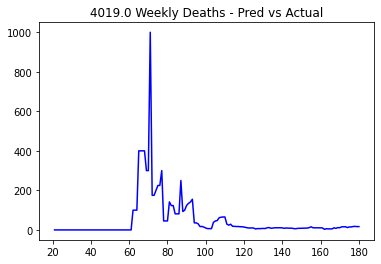

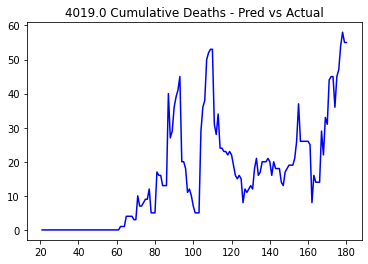

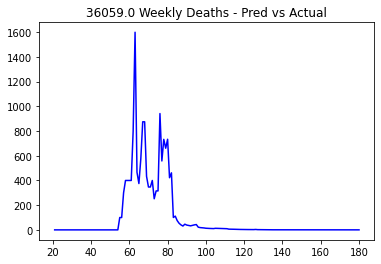

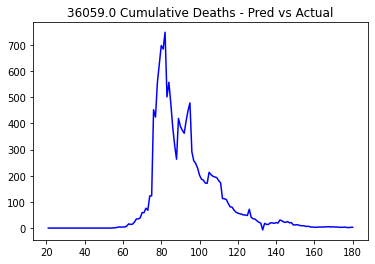

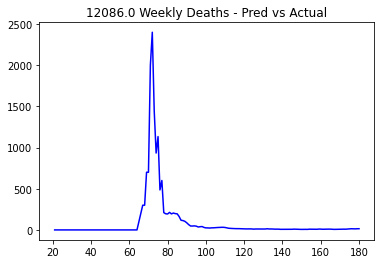

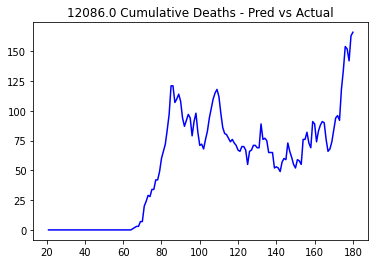

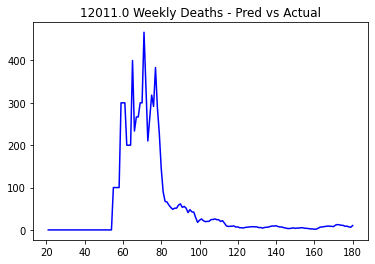

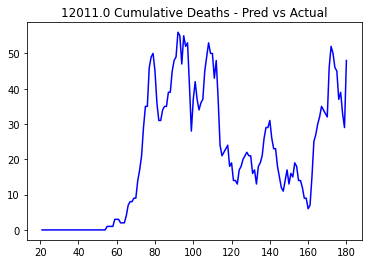

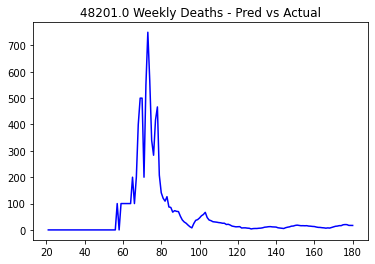

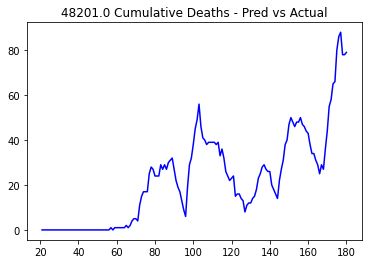

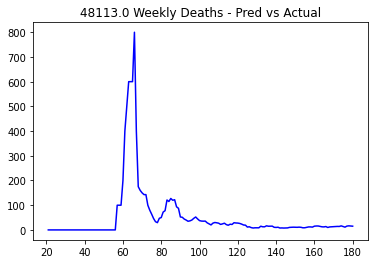

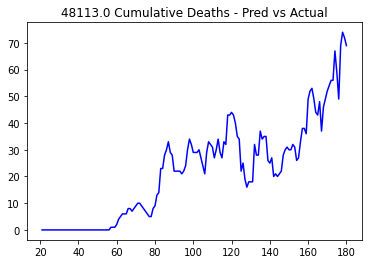

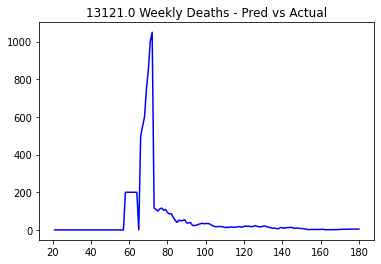

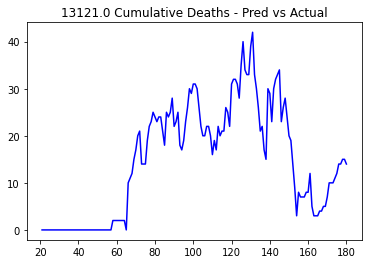

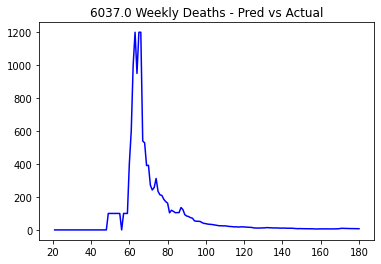

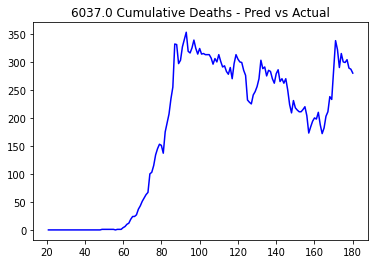

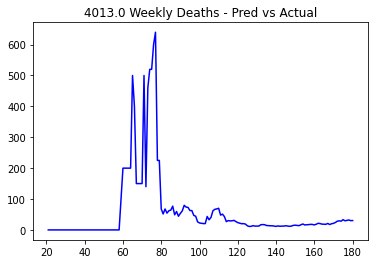

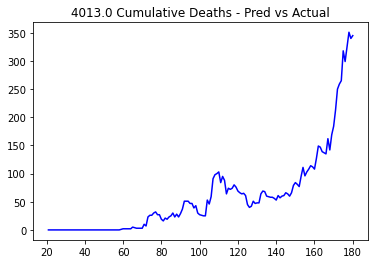

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
FIPS = [ 4019.0,36059.0, 12086.0, 12011.0, 48201.0,48113.0,13121.0,6037.0,  4013.0]
forecast_days = ['2020-05-17', '2020-05-31', '2020-06-14','2020-06-28']

for f in FIPS:
        
    #predicted_df_90 = predicted_df_all_days[(predicted_df_all_days["FIPS"] == f) & (predicted_df_all_days["Forecast_Day"].isin(forecast_days))]

    Deaths_Cases_df = US_Deaths_Cases_df[(US_Deaths_Cases_df["FIPS"] == f) &  (US_Deaths_Cases_df["Days"] >= 21) &(US_Deaths_Cases_df["Days"] <= 180)]

    x = Deaths_Cases_df["Days"]
    #z= predicted_df_90["Predicted_Weekly_Deaths"]
    y = Deaths_Cases_df["Weekly_Deaths_Per"]
    plt.title(str(f) +" Weekly Deaths - Pred vs Actual")
    plt.plot(x, y, "-b", label="actual")
    #plt.plot(x, z, "-r", label="predicted")
    plt.savefig(str(f) + "_Weekly_Deaths.png", dpi=100)   
    plt.show()

    x = Deaths_Cases_df["Days"]
    #z= predicted_df_90["Predicted_Cumulative_Deaths"]
    y = Deaths_Cases_df["Weekly_Deaths"]
    plt.title(str(f) +" Cumulative Deaths - Pred vs Actual")
    plt.plot(x, y, "-b", label="actual")
   # plt.plot(x, z, "-r", label="predicted")
    plt.savefig(str(f) + "_X_Cumulative_Deaths.png", dpi=100)
    plt.show()


In [45]:
from datetime import datetime

covid_start_date = datetime.strptime("01/22/20", "%m/%d/%y")

state_predicted_deaths = predicted_df_all_days.groupby(['State', 'Days', 'Forecast_Day'], as_index=False)[["Predicted_Cumulative_Deaths"]].sum()
state_to_fips=pd.read_csv('https://docs.google.com/spreadsheets/d/1w4sHgYifJV-C8J1WV5rpTzEFLuyZ5ESp8r_1ck-9hlA/export?format=csv')
state_predicted_deaths = state_predicted_deaths.merge(state_to_fips, how='left', left_on=['State'], right_on=['Name'])
state_predicted_deaths=state_predicted_deaths.drop(columns=['Name'])
country_predicted_deaths = predicted_df_all_days.groupby(['Days', 'Forecast_Day'], as_index=False)[["Predicted_Cumulative_Deaths"]].sum()

state_predicted_deaths=state_predicted_deaths[['State','FIPS','Days','Forecast_Day','Predicted_Cumulative_Deaths']]
iteration = 0  
forecast_dates = country_predicted_deaths["Forecast_Day"].unique()
for forecast_date in forecast_dates:
  print(forecast_date)  
  covid_hub_predicted_deaths = pd.DataFrame(columns=['forecast_date','target', 'target_end_date','location', 'location_name','type', 'quantile', 'value']) 
  filename = "forecast-hub/data-processed/MIT_Sak/{}-MIT-Sak.csv".format(forecast_date)
  cp_detahs_forecast= country_predicted_deaths[country_predicted_deaths["Forecast_Day"] == forecast_date]
  for index, row in cp_detahs_forecast.iterrows():

      covid_hub_predicted_deaths.loc[iteration,"location"] = 'US'
      covid_hub_predicted_deaths.loc[iteration,"location_name"] = 'US'
      #predicted_df["FIPS"] = predict_week_df["FIPS"]
      #predicted_df["Days"] = predict_week_df["Days"]
      target_date = (covid_start_date + timedelta(days=row["Days"]))
      forecast_day =  (datetime.strptime(row["Forecast_Day"],"%Y-%m-%d") - covid_start_date).days
      days_from = str(row["Days"] - forecast_day)
      covid_hub_predicted_deaths.loc[iteration,"target"] = days_from + " day ahead cum death"
      covid_hub_predicted_deaths.loc[iteration,"target_end_date"] = target_date.strftime("%Y-%m-%d")
      covid_hub_predicted_deaths.loc[iteration,"forecast_date"] =  row["Forecast_Day"]
      covid_hub_predicted_deaths.loc[iteration,"type"] ="point"
      covid_hub_predicted_deaths.loc[iteration,"quantile"] ="NA"
      if row["Predicted_Cumulative_Deaths"] >= 0:
        covid_hub_predicted_deaths.loc[iteration,"value"] = row["Predicted_Cumulative_Deaths"]
      else:
        covid_hub_predicted_deaths.loc[iteration,"value"] = 0

      iteration = iteration + 1
  state_predicted_deaths_forecast = state_predicted_deaths[state_predicted_deaths["Forecast_Day"] == forecast_date]
  for index, row in state_predicted_deaths_forecast.iterrows():
      covid_hub_predicted_deaths.loc[iteration,"location"] = str(row["FIPS"]).zfill(2)
      covid_hub_predicted_deaths.loc[iteration,"location_name"] = row["State"]
   
      target_date = (covid_start_date + timedelta(days=row["Days"]))
      forecast_day =  (datetime.strptime(row["Forecast_Day"],"%Y-%m-%d") - covid_start_date).days
      days_from = str(row["Days"] - forecast_day)
   
      covid_hub_predicted_deaths.loc[iteration,"target"] = days_from + " day ahead cum death"
      covid_hub_predicted_deaths.loc[iteration,"target_end_date"] = target_date.strftime("%Y-%m-%d")
      covid_hub_predicted_deaths.loc[iteration,"forecast_date"] =  row["Forecast_Day"]
      covid_hub_predicted_deaths.loc[iteration,"type"] ="point"
      covid_hub_predicted_deaths.loc[iteration,"quantile"] ="NA"
      if row["Predicted_Cumulative_Deaths"] >= 0:
        covid_hub_predicted_deaths.loc[iteration,"value"] = row["Predicted_Cumulative_Deaths"]
      else:
        covid_hub_predicted_deaths.loc[iteration,"value"] = 0
      iteration = iteration + 1
  
  covid_hub_predicted_deaths.to_csv(filename,index = False)
  #files.download(filename)


2020-04-12
2020-04-19
2020-04-26
2020-05-03
2020-05-10


In [46]:
import evaluate_models
from datetime import datetime, timedelta
from os import listdir
from os.path import isfile, join
files = listdir('forecast-hub/data-processed/MIT_Sak')
files.sort()
for f in files :
    if f!= '.DS_Store':
        proj_date = datetime.strptime(f[:10],"%Y-%m-%d").date() +  timedelta(days=1) #Monday
        eval_date = proj_date +  timedelta(days=5) #Saturday

        print("running evaluation for proj_date: ", proj_date, " eval_date: " , eval_date)
        evaluate_models.run_evaluation('forecast-hub',proj_date, eval_date, "eval/one-week")


running evaluation for proj_date:  2020-03-30  eval_date:  2020-04-04
Forecast hub dir: forecast-hub
proj_date: 2020-03-30
eval_date: 2020-04-04
out_dir   : eval/one-week
use_point: True
use_cumulative_deaths: False
Days ahead: 5
Fetching file names from COVID-19 Forecast Hub
Auquan-SEIR - No files within range: ['2020-05-18-Auquan-SEIR.csv', '2020-05-24-Auquan-SEIR.csv', '2020-05-31-Auquan-SEIR.csv', '2020-06-07-Auquan-SEIR.csv', '2020-06-15-Auquan-SEIR.csv', '2020-06-21-Auquan-SEIR.csv', '2020-06-28-Auquan-SEIR.csv', '2020-07-05-Auquan-SEIR.csv']
CDDEP-SEIR_MCMC - No files within range: ['2020-07-05-CDDEP-SEIR_MCMC.csv', '2020-07-12-CDDEP-SEIR_MCMC.csv']
COVIDhub-baseline - No files within range: ['2020-04-06-COVIDhub-baseline.csv', '2020-04-13-COVIDhub-baseline.csv', '2020-04-20-COVIDhub-baseline.csv', '2020-04-27-COVIDhub-baseline.csv', '2020-05-04-COVIDhub-baseline.csv', '2020-05-11-COVIDhub-baseline.csv', '2020-05-18-COVIDhub-baseline.csv', '2020-05-25-COVIDhub-baseline.csv', '20

Max projection date: 2020-08-04 - 18.1 weeks ahead
* No median data
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Imperial-ensemble1
Max projection date: 2020-04-04 - 0.7 weeks ahead
Num unique locations (pre-filt) : 1
Num unique locations (post-filt): 1
-----------------------------
Imperial-ensemble2
Max projection date: 2020-04-04 - 0.7 weeks ahead
Num unique locations (pre-filt) : 1
Num unique locations (post-filt): 1
-----------------------------
MIT_Sak
Max projection date: 2020-04-05 - 0.9 weeks ahead
* No median data
Num unique locations (pre-filt) : 50
Num unique locations (post-filt): 50
Begin Evaluation
Number of locations with projections:
Baseline              52
Baseline_0.98         52
IHME-CurveFit         52
Imperial-ensemble1     1
Imperial-ensemble2     1
MIT_Sak               50
dtype: int64
-----------
Combining: Imperial
Num rows, us rows: 2 2
US Evaluation:
                   total_deaths_2020-03-29  predi

Covid19Sim-Simulator - No files within range: ['2020-05-24-Covid19Sim-Simulator.csv', '2020-05-31-Covid19Sim-Simulator.csv', '2020-06-07-Covid19Sim-Simulator.csv', '2020-06-14-Covid19Sim-Simulator.csv', '2020-06-21-Covid19Sim-Simulator.csv', '2020-06-28-Covid19Sim-Simulator.csv', '2020-07-05-Covid19Sim-Simulator.csv', '2020-07-12-Covid19Sim-Simulator.csv']
CovidActNow-SEIR_CAN - No files within range: ['2020-05-09-CovidActNow-SEIR_CAN.csv', '2020-05-31-CovidActNow-SEIR_CAN.csv', '2020-06-07-CovidActNow-SEIR_CAN.csv', '2020-06-14-CovidActNow-SEIR_CAN.csv', '2020-06-21-CovidActNow-SEIR_CAN.csv', '2020-07-05-CovidActNow-SEIR_CAN.csv']
CovidAnalytics-DELPHI - No files within range: ['2020-04-27-CovidAnalytics-DELPHI.csv', '2020-04-30-CovidAnalytics-DELPHI.csv', '2020-05-04-CovidAnalytics-DELPHI.csv', '2020-05-10-CovidAnalytics-DELPHI.csv', '2020-05-18-CovidAnalytics-DELPHI.csv', '2020-05-25-CovidAnalytics-DELPHI.csv', '2020-06-01-CovidAnalytics-DELPHI.csv', '2020-06-08-CovidAnalytics-DELPH

Max projection date: 2020-05-30 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
IHME-CurveFit
Max projection date: 2020-08-04 - 17.1 weeks ahead
* No median data
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Imperial-ensemble1
Max projection date: 2020-04-11 - 0.7 weeks ahead
Num unique locations (pre-filt) : 1
Num unique locations (post-filt): 1
-----------------------------
Imperial-ensemble2
Max projection date: 2020-04-11 - 0.7 weeks ahead
Num unique locations (pre-filt) : 1
Num unique locations (post-filt): 1
-----------------------------
LANL-GrowthRate
Max projection date: 2020-05-23 - 6.7 weeks ahead
Num unique locations (pre-filt) : 53
Num unique locations (post-filt): 51
-----------------------------
MIT_Sak
Max projection date: 2020-04-19 - 1.9 weeks ahead
* No median data
Num unique locations (pre-filt) : 50
Num unique locations (post-filt): 

Max projection date: 2020-06-06 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-05-23 - 5.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-05-23 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
IHME-CurveFit
Max projection date: 2020-08-04 - 16.1 weeks ahead
* No median data
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Imperial-ensemble1
Max projection date: 2020-04-18 - 0.7 weeks ahead
Num unique locations (pre-filt) : 1
Num unique locations (post-filt): 1


------------------------
State-by-state mean absolute errors:
                   Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  Kentucky  \
Baseline             -18.9     0.7     -2.7      -1.6      -249.7       5.7       -219.1     -14.0                 -17.0    -81.3    -49.7     4.3   -1.4    -156.7    -16.9 -13.3     0.1      -2.4   
Baseline_0.98        -20.9     0.6     -5.3      -2.0      -261.9      -0.5       -234.4     -14.9                 -18.2    -91.3    -59.0     4.1   -2.1    -175.3    -25.9 -14.2    -1.3      -4.6   
COVIDhub-baseline    -13.0     2.0    -16.0      -2.0      -219.0     -22.0       -263.0     -15.0                 -18.0    -67.0    -16.0     4.0   -3.0    -149.0     -1.0 -20.0     4.0      -4.0   
COVIDhub-ensemble     -0.8     2.2     -4.8      -0.6      -232.0     -15.1        -52.2     -15.1                 -15.8     48.4     44.4

Max projection date: 2020-06-13 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-05-30 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
Geneva-DetGrowth
Max projection date: 2020-04-25 - 0.7 weeks ahead
* No median data
Num unique locations (pre-filt) : 1
Num unique locations (post-filt): 1
-----------------------------
IHME-CurveFit
Max projection date: 2020-08-04 - 15.1 weeks ahead
* No median data
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Imperial-ensemble1
Max projection date: 2020-04-25 - 0.7 weeks ahead
Num unique locations (pre-filt) : 1
Num unique locations (

Max projection date: 2020-06-20 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-05-23 - 3.7 weeks ahead
Num unique locations (pre-filt) : 54
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-06-06 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
CovidAnalytics-DELPHI
Max projection date: 2020-06-06 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
Geneva-DetGrowth
Max projection date: 2020-05-02 - 0.7 weeks ahead
* No median data
Num unique locations (pre-filt) : 1
Num unique locations (post-filt

                       count      mean  median        std  min    25%     75%         max
COVIDhub-baseline       51.0   13307.1   196.0    67796.1  0.0   12.5  1948.5    483025.0
YYG-ParamSearch         51.0   14980.0   110.3    54279.7  0.0    8.1  1215.5    276597.3
Baseline_0.98           51.0   20623.2    97.2    83215.3  0.0   14.1  1541.9    507545.7
Baseline                51.0   24024.3   114.8   110197.6  0.0   11.4  3185.1    750450.9
MOBS-GLEAM_COVID        51.0   42257.7   721.1   121279.6  0.1   13.7  8040.3    720729.3
LANL-GrowthRate         51.0   44093.7   191.9   186226.2  0.0   16.0  4871.0   1275996.7
IHME-CurveFit           51.0   63382.8   395.4   246529.7  0.1   42.8  3655.4   1354928.6
CovidAnalytics-DELPHI   51.0  112342.0   784.0   764838.7  0.0   25.0  3485.0   5466244.0
COVIDhub-ensemble       51.0  125822.5   286.3   850463.0  0.2    9.3  2553.0   6078012.0
IowaStateLW-STEM        51.0  165290.4   784.0  1109244.3  0.0   90.5  6644.5   7929856.0
UMass-Mech

Max projection date: 2020-06-27 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-05-30 - 3.7 weeks ahead
Num unique locations (pre-filt) : 54
Num unique locations (post-filt): 52
-----------------------------
CU-scenario_high
-----------------------------
CU-select
Max projection date: 2020-06-13 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
CovidAnalytics-DELPHI
Max projection date: 2020-06-13 - 5.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
GT-DeepCOVID
Max projection date: 2020-05-18 - 2.0 weeks ahead
Num unique locations (pre-filt) : 48
Num unique locations (post-filt): 48
-----------------------------
Geneva-DetGrowth
Max projection date: 2020-05-09 - 0.7 weeks ahead
* No median data
Num unique locations (pre-filt) : 

                       Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Baseline                 -39.1    -1.0    -95.4       9.4       -50.1       7.0        -57.1       4.9                   2.6    -75.4     10.7     2.6    3.9    -143.9    -84.6 -11.4   -10.3   
Baseline_0.98            -42.1    -1.0    -99.1       8.4       -70.6       0.6        -78.5       2.5                  -0.5    -88.1     -0.5     2.4    3.5    -172.4    -97.9 -14.2   -11.2   
COVIDhub-baseline        -23.0    -1.0   -145.0       8.0       -16.0      13.0         75.0       3.0                   4.0    -42.0     44.0     2.0    5.0    -106.0    -46.0 -14.0   -10.0   
COVIDhub-ensemble        -39.3     1.2    -99.9       1.5        20.7      44.3         15.6       8.2                   3.9   -115.8    -29.3     1.7    4.4     -44.5    -69.6  18.5     8.5   
CU-select                -56.0

Max projection date: 2020-07-04 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-06-06 - 3.7 weeks ahead
Num unique locations (pre-filt) : 54
Num unique locations (post-filt): 52
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-06-20 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
CovidActNow-SEIR_CAN
Max projection date: 2020-05-23 - 1.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
CovidAnalytics-DELPHI
Max projection date: 2020-06-13 - 4.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------

dtype: int64
------------------------
Cumulative death forecasts for 2020-05-16:
                      actual_deaths  Baseline  Baseline_0.98  COVIDhub-baseline  COVIDhub-ensemble  CU-select  CovidAnalytics-DELPHI  GT-DeepCOVID  Geneva-DetGrowth  IHME-CurveFit  \
Alabama                       485.0     481.3          477.0              492.0              470.1      453.0                  445.0           nan               nan          504.5   
Alaska                         10.0      10.9           10.8               11.0               11.7       16.0                    9.0           nan               nan            5.0   
Arizona                       679.0     685.1          677.9              734.0              644.5      633.0                  613.0           nan               nan          658.6   
Arkansas                       98.0     103.9          103.2              104.0              105.4       98.0                  105.0         104.2               nan          105.6   
Cali

Fetching file names from COVID-19 Forecast Hub
Auquan-SEIR - Found file: 2020-05-18-Auquan-SEIR.csv
CDDEP-SEIR_MCMC - No files within range: ['2020-07-05-CDDEP-SEIR_MCMC.csv', '2020-07-12-CDDEP-SEIR_MCMC.csv']
COVIDhub-baseline - Found file: 2020-05-18-COVIDhub-baseline.csv
COVIDhub-ensemble - Found file: 2020-05-18-COVIDhub-ensemble.csv
CU-nochange - No files within range: ['2020-04-12-CU-nochange.csv', '2020-04-16-CU-nochange.csv', '2020-04-19-CU-nochange.csv', '2020-04-23-CU-nochange.csv', '2020-04-26-CU-nochange.csv', '2020-05-31-CU-nochange.csv', '2020-06-04-CU-nochange.csv', '2020-06-07-CU-nochange.csv', '2020-06-11-CU-nochange.csv', '2020-06-14-CU-nochange.csv', '2020-06-18-CU-nochange.csv', '2020-06-21-CU-nochange.csv', '2020-06-25-CU-nochange.csv', '2020-06-28-CU-nochange.csv', '2020-07-02-CU-nochange.csv', '2020-07-05-CU-nochange.csv', '2020-07-12-CU-nochange.csv']
CU-scenario_high - Found file: 2020-05-17-CU-scenario_high.csv
CU-scenario_low - Found file: 2020-05-17-CU-scena

Max projection date: 2020-06-15 - 4.0 weeks ahead
Num unique locations (pre-filt) : 26
Num unique locations (post-filt): 26
-----------------------------
Geneva-DetGrowth
Max projection date: 2020-05-23 - 0.7 weeks ahead
* No median data
Num unique locations (pre-filt) : 1
Num unique locations (post-filt): 1
-----------------------------
IHME-CurveFit
Max projection date: 2020-08-08 - 11.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Imperial-ensemble1
Max projection date: 2020-05-23 - 0.7 weeks ahead
Num unique locations (pre-filt) : 1
Num unique locations (post-filt): 1
-----------------------------
Imperial-ensemble2
Max projection date: 2020-05-23 - 0.7 weeks ahead
Num unique locations (pre-filt) : 1
Num unique locations (post-filt): 1
-----------------------------
IowaStateLW-STEM
Max projection date: 2020-09-19 - 17.7 weeks ahead
Num unique locations (pre-filt) : 50
Num unique locations (post-filt): 50
-------

                       count          mean     median           std  min       25%         75%            max
UT-Mobility             51.0        3228.2      130.6        7217.0  0.0       3.4      1220.9        30600.0
UMass-MechBayes         51.0        3374.7      100.0        9088.3  0.0      16.0      1521.0        54756.0
UCLA-SuEIR              51.0        3633.8      224.3       10880.3  0.3       9.9      1169.3        65982.8
YYG-ParamSearch         51.0        3677.4       98.0       13069.9  0.3      10.3      1032.5        88314.9
LANL-GrowthRate         51.0        5669.6      112.7       19869.4  0.0       7.1      1273.0       136628.1
Baseline_0.98           51.0        7323.1      116.3       36514.6  0.0      16.9      1156.7       259406.7
COVIDhub-baseline       51.0        8875.1      289.0       34522.7  0.0      20.5       841.0       217156.0
Baseline                51.0        9340.1      121.0       46901.6  0.0       6.6      1201.8       331446.9
COVIDhub-e

Max projection date: 2020-07-18 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-06-20 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-06-22 - 4.0 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
Covid19Sim-Simulator
Max projection date: 2020-10-10 - 19.7 weeks ahead
Num unique locations (pre-filt) : 53
Num unique locations (post-filt): 52
-----------------------------
CovidAnalytics-DELPHI
Max projection date: 2020-06-27 - 4.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
GT-DeepCOVID
Max 

Saved to: eval/one-week/2020-05-30/2020-05-25_2020-05-30_us_errs.csv
State-by-state Evaluation:
Number of states with valid projections:
Auquan-SEIR              51
Baseline                 51
Baseline_0.98            51
COVIDhub-baseline        51
COVIDhub-ensemble        51
CU-select                50
Covid19Sim-Simulator     51
CovidAnalytics-DELPHI    51
IowaStateLW-STEM         49
JHU_IDD-CovidSP          51
LANL-GrowthRate          51
MIT_Sak                  49
MOBS-GLEAM_COVID         50
PSI-DRAFT                51
UA-EpiCovDA              51
UCLA-SuEIR               51
UMass-MechBayes          51
USACE-ERDC_SEIR          51
UT-Mobility              51
YYG-ParamSearch          51
dtype: int64
------------------------
Cumulative death forecasts for 2020-05-30:
                      actual_deaths  Baseline  Baseline_0.98  Auquan-SEIR  COVIDhub-baseline  COVIDhub-ensemble  CU-select  Covid19Sim-Simulator  CovidAnalytics-DELPHI  GT-DeepCOVID  \
Alabama                       618.0  

                       count    mean  median     std  min    25%     75%      max
UMass-MechBayes         51.0    14.3    10.0    17.0  0.0    2.0    16.0     68.0
YYG-ParamSearch         51.0    24.9     8.1    37.6  0.1    1.7    33.3    151.8
COVIDhub-ensemble       51.0    25.4    12.9    34.7  0.3    3.8    24.6    145.5
Baseline_0.98           51.0    25.4     8.4    38.2  0.0    2.1    29.8    168.2
LANL-GrowthRate         51.0    26.4    13.0    43.1  0.1    2.2    28.2    244.0
UCLA-SuEIR              51.0    30.0    12.8    43.2  0.1    5.3    36.4    219.7
Baseline                51.0    30.0     9.6    46.4  0.0    2.6    33.3    206.1
MOBS-GLEAM_COVID        51.0    33.3     7.7    57.8  0.2    2.7    34.7    261.4
UT-Mobility             51.0    33.5    15.0    44.5  0.0    4.5    48.5    204.0
CovidAnalytics-DELPHI   51.0    33.9    13.0    50.1  0.0    3.0    40.5    205.0
CU-select               51.0    40.1    20.0    54.4  0.0    8.0    63.0    300.0
COVIDhub-baselin

Max projection date: 2020-07-25 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-06-27 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-06-29 - 4.0 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
Covid19Sim-Simulator
Max projection date: 2020-10-17 - 19.7 weeks ahead
Num unique locations (pre-filt) : 53
Num unique locations (post-filt): 52
-----------------------------
CovidActNow-SEIR_CAN
Max projection date: 2020-06-27 - 3.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
------

Saved to: eval/one-week/2020-06-06/projections_2020-06-01_2020-06-06.csv
------------------------
State-by-state mean absolute errors:
                       Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Auquan-SEIR              124.0     5.0    125.0      47.0       682.0     331.0        419.0      95.0                  99.0    313.0    270.0     8.0   33.0    1086.0    267.0 139.0    94.0   
Baseline                   8.7     0.0    -45.1      -6.4       -75.9      14.9        104.1      10.3                  12.1    -53.6     68.7     0.0    1.6     -16.3    -22.6   3.7    -9.4   
Baseline_0.98              5.4     0.0    -49.6      -7.1       -93.3      10.1         93.7       8.6                  10.7    -62.5     59.3     0.0    1.4     -38.6    -29.2   0.4    -9.8   
COVIDhub-baseline         -2.0     0.0    -36.0      -3.0       -56.0      32.0         9

Max projection date: 2020-07-04 - 3.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-baseline
Max projection date: 2020-08-01 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-07-04 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-07-06 - 4.0 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Covid19Sim-Simulator
Max projection date: 2020-10-24 - 19.7 weeks ahead
Num unique locations (pre-filt) : 53
Num unique locations (post-filt): 52
---------

                      actual_deaths  Baseline  Baseline_0.98  Auquan-SEIR  COVIDhub-baseline  COVIDhub-ensemble  CU-select  Covid19Sim-Simulator  CovidActNow-SEIR_CAN  CovidAnalytics-DELPHI  \
Alabama                       773.0     745.1          742.6        906.0              760.0              754.1      776.0                 699.8                 786.7                  796.0   
Alaska                         12.0      10.0           10.0         14.0               10.0               10.4       10.0                  10.7                  14.3                   10.0   
Arizona                      1189.0    1174.4         1168.4       1382.0             1182.0             1231.0     1296.0                1008.0                1264.5                 1361.0   
Arkansas                      177.0     172.0          171.1        247.0              175.0              178.0      214.0                 162.5                 203.3                  174.0   
California                   5076.0

                       count  mean  median   std  min  25%   75%    max
YYG-ParamSearch         51.0  15.2     5.0  23.3  0.3  2.2  19.4  136.3
COVIDhub-ensemble       51.0  18.2     8.0  27.0  0.0  1.9  22.6  131.4
UMass-MechBayes         51.0  21.0     6.0  40.6  0.0  2.0  21.0  219.0
Baseline_0.98           51.0  23.9     6.9  45.3  0.0  2.7  21.3  243.4
OliverWyman-Navigator   51.0  23.9     9.7  33.6  0.0  2.3  30.5  158.4
Baseline                51.0  25.1     7.6  48.5  0.0  3.1  15.0  260.3
UT-Mobility             51.0  26.2     7.0  48.7  0.3  3.4  21.6  199.8
LANL-GrowthRate         51.0  26.5     8.1  44.9  0.1  3.8  24.8  219.7
COVIDhub-baseline       51.0  27.9     9.0  49.8  0.0  3.5  23.5  234.0
UCLA-SuEIR              51.0  28.4    10.0  36.8  0.2  2.4  31.6  136.8
MOBS-GLEAM_COVID        51.0  33.6    12.2  51.9  0.4  4.0  34.4  237.4
Geneva-DetGrowth        51.0  34.2    15.0  51.4  0.0  4.5  47.5  302.0
CovidAnalytics-DELPHI   51.0  37.5    14.0  53.8  0.0  3.0  54.5

Max projection date: 2020-08-08 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-07-11 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-07-13 - 4.0 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Covid19Sim-Simulator
Max projection date: 2020-10-31 - 19.7 weeks ahead
Num unique locations (pre-filt) : 53
Num unique locations (post-filt): 52
-----------------------------
CovidActNow-SEIR_CAN
Max projection date: 2020-07-11 - 3.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
------

------------------------
Cumulative death forecasts for 2020-06-20:
                      actual_deaths  Baseline  Baseline_0.98  Auquan-SEIR  COVIDhub-baseline  COVIDhub-ensemble  CU-select  Covid19Sim-Simulator  CovidActNow-SEIR_CAN  CovidAnalytics-DELPHI  \
Alabama                       838.0     842.4          839.0       1059.0              857.0              859.1      906.0                 870.3                 838.2                  877.0   
Alaska                         12.0      13.7           13.6         17.0               14.0               13.0       12.0                  12.0                  14.9                   12.0   
Arizona                      1346.0    1311.0         1305.2       1788.0             1335.0             1386.1     1476.0                1521.6                1387.1                 1619.0   
Arkansas                      224.0     200.4          199.4        314.0              200.0              206.2      217.0                 179.1                

                       count  mean  median   std  min  25%   75%    max
YYG-ParamSearch         51.0  12.8     6.2  16.8  0.2  1.6  17.6   79.5
UMass-MechBayes         51.0  13.3     7.0  17.3  0.0  2.0  18.5   70.0
UCLA-SuEIR              51.0  15.7     8.1  20.0  0.1  2.7  20.6   88.7
OliverWyman-Navigator   51.0  17.0     8.5  20.6  0.0  2.6  24.5   90.0
Baseline_0.98           51.0  17.9     6.2  29.1  0.0  1.2  21.2  132.8
Baseline                51.0  19.8     5.3  32.5  0.0  1.9  23.4  151.6
COVIDhub-ensemble       51.0  20.3     9.5  23.2  0.1  2.4  29.3   93.8
MOBS-GLEAM_COVID        51.0  23.1     9.1  28.2  0.1  2.8  38.6  106.9
UA-EpiCovDA             51.0  24.9    10.0  29.2  0.0  3.0  44.5  114.0
UT-Mobility             51.0  27.6     9.0  55.0  0.0  2.5  29.0  313.0
COVIDhub-baseline       51.0  28.1    11.0  47.8  0.0  2.0  32.0  250.0
LANL-GrowthRate         51.0  28.6    12.9  40.1  0.3  2.6  35.5  213.7
PSI-DRAFT               51.0  32.6    10.0  84.1  0.0  3.0  32.0

Max projection date: 2020-08-15 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-07-18 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-07-20 - 4.0 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Covid19Sim-Simulator
Max projection date: 2020-11-07 - 19.7 weeks ahead
Num unique locations (pre-filt) : 53
Num unique locations (post-filt): 52
-----------------------------
CovidActNow-SEIR_CAN
Max projection date: 2020-07-18 - 3.7 weeks ahead
Num unique locations (pre-filt) : 43
Num unique locations (post-filt): 43
------

                      actual_deaths  Baseline  Baseline_0.98  Auquan-SEIR  COVIDhub-baseline  COVIDhub-ensemble  CU-select  Covid19Sim-Simulator  CovidActNow-SEIR_CAN  CovidAnalytics-DELPHI  \
Alabama                       919.0     895.6          892.8        912.0              903.0              915.8     1001.0                 933.6                 976.4                  968.0   
Alaska                         14.0      12.0           12.0         13.0               12.0               12.6       12.0                  13.1                  18.6                   13.0   
Arizona                      1580.0    1484.4         1477.8       1595.0             1503.0             1583.4     1881.0                1693.1                   nan                 1687.0   
Arkansas                      259.0     264.4          262.5        266.0              271.0              265.5      316.0                 213.4                 296.4                  261.0   
California                   5899.0

                       count  mean  median   std  min  25%   75%    max
YYG-ParamSearch         51.0  50.3     7.0 254.7  0.0  2.4  19.0 1828.9
UCLA-SuEIR              51.0  51.7     9.5 244.9  0.2  3.4  29.2 1761.6
Baseline                51.0  52.2    11.1 246.2  0.3  1.8  26.3 1769.0
Baseline_0.98           51.0  52.3     9.7 247.8  0.3  2.8  26.2 1780.7
UMass-MechBayes         51.0  53.3    11.0 253.5  0.0  3.5  23.5 1821.0
COVIDhub-baseline       51.0  53.4    10.0 239.1  0.0  4.5  36.0 1721.0
COVIDhub-ensemble       51.0  53.4     6.1 248.4  0.0  2.0  30.8 1783.3
UA-EpiCovDA             51.0  55.1    11.0 263.5  0.0  4.0  27.5 1894.0
UT-Mobility             51.0  56.4    10.0 243.9  0.0  2.5  33.5 1751.0
OliverWyman-Navigator   51.0  58.6    12.9 252.8  0.5  3.6  37.4 1818.4
MOBS-GLEAM_COVID        51.0  61.1    13.1 251.2  0.4  5.0  37.1 1808.2
CovidAnalytics-DELPHI   51.0  65.5    12.0 265.7  0.0  4.0  29.0 1897.0
LANL-GrowthRate         51.0  68.4    13.5 249.5  0.4  3.5  52.3

Max projection date: 2020-08-22 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-07-25 - 3.7 weeks ahead
Num unique locations (pre-filt) : 57
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-07-27 - 4.0 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Covid19Sim-Simulator
Max projection date: 2020-11-14 - 19.7 weeks ahead
Num unique locations (pre-filt) : 53
Num unique locations (post-filt): 52
-----------------------------
CovidAnalytics-DELPHI
Max projection date: 2020-08-01 - 4.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----

                       count     mean  median      std  min   25%     75%       max
YYG-ParamSearch         51.0    436.8    32.2   1011.3  0.0   3.7   328.3    5679.4
COVIDhub-ensemble       51.0    920.1   118.8   3328.1  0.0   9.9   538.8   22851.9
OliverWyman-Navigator   51.0   1076.2    61.9   2559.5  0.0  13.2   800.2   14718.3
UT-Mobility             51.0   1163.0    49.0   3292.4  0.0   4.0   462.5   18496.0
UMass-MechBayes         51.0   1297.6    25.0   4473.0  0.0   4.0   361.0   27225.0
UCLA-SuEIR              51.0   1612.6    61.8   4285.3  0.0   8.9   726.1   25663.2
SWC-TerminusCM          51.0   1636.3   169.0   3609.0  0.0  26.0  1370.0   17424.0
LANL-GrowthRate         51.0   1835.8   346.7   4268.1  0.0   5.8  1247.6   23086.9
IHME-CurveFit           51.0   2178.6   107.6   6953.8  0.0  17.9   641.6   43539.9
USC-SI_kJalpha          51.0   2344.7   121.0   7254.0  0.0   4.8   669.5   38921.6
MOBS-GLEAM_COVID        51.0   3404.8   304.6   9978.1  0.0  16.1  1906.3   

Max projection date: 2020-08-29 - 7.7 weeks ahead
Num unique locations (pre-filt) : 24
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
COVIDhub-baseline
Max projection date: 2020-08-29 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-08-01 - 3.7 weeks ahead
Num unique locations (pre-filt) : 57
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-08-15 - 5.7 weeks ahead
Num unique locations (pre-filt) : 3192
Num unique locations (post-filt): 52
-----------------------------
Columbia_UNC-SurvCon
Max projection date: 2020-08-29 - 7.7 weeks ahead
Num unique locations (pre-filt) : 1
Num unique loca

                       count      mean  median       std  min   25%     75%        max
COVIDhub-ensemble       51.0    2835.7   115.1    9579.2  0.1   6.5   636.4    58686.2
USC-SI_kJalpha          51.0    3486.0   109.9   13083.5  0.0   7.8   780.9    83220.1
UMass-MechBayes         51.0    4190.9   121.0   13528.3  0.0   4.0   485.0    65025.0
OliverWyman-Navigator   51.0    4257.5    68.0   14703.5  0.1   8.7   392.0    72714.4
USACE-ERDC_SEIR         51.0    4395.2   104.8   12812.8  0.0  24.1  1252.7    64483.5
UCLA-SuEIR              51.0    4855.2   139.0   16628.6  0.0  36.4  1310.3    92367.5
LANL-GrowthRate         51.0    4998.0    89.0   23003.6  0.0   4.5   567.0   162226.5
UT-Mobility             51.0    5010.5   121.0   13400.3  0.0  16.0  2682.5    65025.0
COVIDhub-baseline       51.0    5331.5    81.0   16967.1  0.0  17.0   962.0    89401.0
MOBS-GLEAM_COVID        51.0    5604.6   314.9   15530.5  0.0  21.0  1859.0    73123.6
JHU_IDD-CovidSP         51.0    5675.2   50

KeyError: 'US'

In [ ]:

for f in files :
    if f!= '.DS_Store':
        proj_date = datetime.strptime(f[:10],"%Y-%m-%d").date() +  timedelta(days=1) #Monday
        eval_date = proj_date +  timedelta(days=12) #Saturday

        print("running evaluation for proj_date: ", proj_date, " eval_date: " , eval_date)
        evaluate_models.run_evaluation('forecast-hub',proj_date, eval_date, "eval/two-weeks")

running evaluation for proj_date:  2020-03-30  eval_date:  2020-04-11
Forecast hub dir: forecast-hub
proj_date: 2020-03-30
eval_date: 2020-04-11
out_dir   : eval/two-weeks
use_point: True
use_cumulative_deaths: False
Days ahead: 12
Fetching file names from COVID-19 Forecast Hub
Auquan-SEIR - No files within range: ['2020-05-18-Auquan-SEIR.csv', '2020-05-24-Auquan-SEIR.csv', '2020-05-31-Auquan-SEIR.csv', '2020-06-07-Auquan-SEIR.csv', '2020-06-15-Auquan-SEIR.csv', '2020-06-21-Auquan-SEIR.csv', '2020-06-28-Auquan-SEIR.csv', '2020-07-05-Auquan-SEIR.csv']
CDDEP-SEIR_MCMC - No files within range: ['2020-07-05-CDDEP-SEIR_MCMC.csv', '2020-07-12-CDDEP-SEIR_MCMC.csv']
COVIDhub-baseline - No files within range: ['2020-04-06-COVIDhub-baseline.csv', '2020-04-13-COVIDhub-baseline.csv', '2020-04-20-COVIDhub-baseline.csv', '2020-04-27-COVIDhub-baseline.csv', '2020-05-04-COVIDhub-baseline.csv', '2020-05-11-COVIDhub-baseline.csv', '2020-05-18-COVIDhub-baseline.csv', '2020-05-25-COVIDhub-baseline.csv', '

------------------------
State-by-state mean absolute errors:
               Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  Kentucky  \
Baseline         -63.4    -2.3    -72.1      -7.9      -305.4    -150.9       -411.7     -15.9                 -36.4   -302.1   -246.9    -8.0  -10.7    -505.1   -249.7 -22.6   -38.7     -69.9   
Baseline_0.98    -65.5    -2.7    -75.3      -9.1      -324.9    -159.4       -417.1     -17.1                 -37.1   -311.1   -258.3    -8.0  -11.8    -517.0   -255.1 -23.4   -39.8     -71.1   
IHME-CurveFit     64.7    12.9     41.8      62.7       161.4     134.6       -332.7      11.3                  44.9    -45.3     18.6    -1.8   13.0     -59.8   -119.6 106.1    12.4     -37.8   

               Louisiana  Maine  Maryland  Massachusetts  Michigan  Minnesota  Mississippi  Missouri  Montana  Nebraska  Nevada  New Hampshire  New Jerse

Max projection date: 2020-05-30 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
IHME-CurveFit
Max projection date: 2020-08-04 - 17.1 weeks ahead
* No median data
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Imperial-ensemble1
Max projection date: 2020-04-11 - 0.7 weeks ahead
* No point data
* No median data
Num unique locations (pre-filt) : 0
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
Imperial-ensemble2
Max projection date: 2020-04-11 - 0.7 weeks ahead
* No point data
* No median data
Num unique locations (pre-filt) : 0
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
LANL-GrowthRate
Max projection date: 2020-05-23 - 6.7 weeks ahead
Num unique locations (pre-filt) : 53
Num unique locations (post-filt): 51
-----------------------------
MIT_Sak
Max proj

YYG-ParamSearch - Found file: 2020-04-13-YYG-ParamSearch.csv
epiforecasts-ensemble1 - No files within range: ['2020-06-15-epiforecasts-ensemble1.csv', '2020-06-22-epiforecasts-ensemble1.csv', '2020-06-29-epiforecasts-ensemble1.csv', '2020-07-06-epiforecasts-ensemble1.csv', '2020-07-13-epiforecasts-ensemble1.csv']
----------------------------------
Past truth file: /Users/saksun/work/covid-forecaster/truth/truth-cumulative-deaths-2020-04-30.csv
Incident US deaths: 27969
Loading model projections
-----------------------------
COVIDhub-baseline
Max projection date: 2020-06-06 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-05-23 - 5.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-------------------

                   Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  Kentucky  \
Baseline             -26.9     2.7    -34.7      -0.6      -506.7    -118.3       -633.1     -38.0                 -63.0   -148.3    -61.7     5.3    2.6    -326.7    -41.9 -28.3    -0.9     -11.4   
Baseline_0.98        -36.8     2.3    -47.4      -2.9      -567.2    -149.2       -708.8     -42.4                 -68.8   -198.0   -107.7     4.2   -1.0    -419.2    -86.6 -33.1    -7.9     -22.2   
COVIDhub-baseline    -21.0     5.0    -53.0      -1.0      -452.0    -156.0       -713.0     -41.0                 -66.0   -131.0    -22.0     5.0   -1.0    -332.0    -28.0 -38.0     3.0     -15.0   
COVIDhub-ensemble     34.5     6.5      0.3       6.0      -465.1    -166.1       -101.6     -40.7                 -61.9    236.5    200.9    20.6  -11.1    -197.1     14.7  14.9    28.2     137.5   


Max projection date: 2020-06-13 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-05-30 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
Geneva-DetGrowth
Max projection date: 2020-04-25 - 0.7 weeks ahead
* No point data
* No median data
Num unique locations (pre-filt) : 0
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
IHME-CurveFit
Max projection date: 2020-08-04 - 15.1 weeks ahead
* No median data
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Imperial-ensemble1
Max projection date: 2020-04-25 - 0.7 weeks ahead
* No point

CU-select - Found file: 2020-04-26-CU-select.csv
Columbia_UNC-SurvCon - No files within range: ['2020-07-05-Columbia_UNC-SurvCon.csv', '2020-07-12-Columbia_UNC-SurvCon.csv']
Covid19Sim-Simulator - No files within range: ['2020-05-24-Covid19Sim-Simulator.csv', '2020-05-31-Covid19Sim-Simulator.csv', '2020-06-07-Covid19Sim-Simulator.csv', '2020-06-14-Covid19Sim-Simulator.csv', '2020-06-21-Covid19Sim-Simulator.csv', '2020-06-28-Covid19Sim-Simulator.csv', '2020-07-05-Covid19Sim-Simulator.csv', '2020-07-12-Covid19Sim-Simulator.csv']
CovidActNow-SEIR_CAN - No files within range: ['2020-05-09-CovidActNow-SEIR_CAN.csv', '2020-05-31-CovidActNow-SEIR_CAN.csv', '2020-06-07-CovidActNow-SEIR_CAN.csv', '2020-06-14-CovidActNow-SEIR_CAN.csv', '2020-06-21-CovidActNow-SEIR_CAN.csv', '2020-07-05-CovidActNow-SEIR_CAN.csv']
CovidAnalytics-DELPHI - Found file: 2020-04-27-CovidAnalytics-DELPHI.csv
GT-DeepCOVID - No files within range: ['2020-05-04-GT-DeepCOVID.csv', '2020-05-11-GT-DeepCOVID.csv', '2020-05-18-

Max projection date: 2020-06-20 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-05-23 - 3.7 weeks ahead
Num unique locations (pre-filt) : 54
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-06-06 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
CovidAnalytics-DELPHI
Max projection date: 2020-06-06 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
Geneva-DetGrowth
Max projection date: 2020-05-02 - 0.7 weeks ahead
* No point data
* No median data
Num unique locations (pre-filt) : 0
Num unique loca

----------------------------------
Past truth file: /Users/saksun/work/covid-forecaster/truth/truth-cumulative-deaths-2020-05-04.csv
Incident US deaths: 21115
Loading model projections
-----------------------------
COVIDhub-baseline
